# Introduction
My wife and I are both interested by our geneology, and subsequently have an [Ancestry account](www.ancestry.com).  When it came time to renew our account, we had to take a look at the budget due to me being in grad school (and thus foregoing the income I previously had).

We both have family that reaches *really* far back (...in American terms), and have put in a lot of time to put everything together.  I found out you can extract a [GEDCOM](https://en.wikipedia.org/wiki/GEDCOM) (**Ge**neological **D**ata **Com**munication) file, and since I was trying to improve my Python data munging skills, I thought - why not analyze my ancestry?

There are a few Python packages out there that will load a GEDCOM file directly into Python, but I ended up using the GNU program [GRAMPS](https://gramps-project.org/) to convert it into a series of CSVs.  GRAMPS technically does about 80% of what I wanted to do - and is ironically built with Python - but just using it wouldn't be nearly as fun.

# Questions to Explore
- What were the family names of my ancestors?
- Which states contained the most births or deaths by decade?
- What was the mobility over time?  Specifically in terms of moving to other states.
- How has life expectancy changed over time?


# Caveats
In addition to the data being **really** messy, there are a few restrictions that will impact some of the analysis:
* The basic Ancestry account will only pull records for those residing in the United States
* While my mom's side of the family in the US goes back to colonial times, my dad's side of the family are relatively recent immigrants from Italy, so this will show when looking at specific things like countries of birth
- Time won on some of some of the time vs. quality tradeoffs due to the level of the how messy some of the data is.  My favorite example being "somewhere in the delta" being listed as a birth place.  This may be worth fixing in a professional setting for looking at the state and country of birth, but wasn't worth the time to fix it for my purposes

With that all said, let's get started!

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from chorogrid import Colorbin, Chorogrid  # For plotting choropleth maps
from colour import Color  # Easily creating colors for the maps

plt.style.use('seaborn-deep')  # Keeps plot aesthetics consistent
pd.set_option('display.max_columns', None)  # Displays all columns for wide data frames

%matplotlib inline

# Part I
## The Data
We have four CSVs at our disposal:
- **Individual Detail**: The bulk of our data - one row for every individual with various information shown below
- **Marriage Detail**: The husband/wife, date, place of marriage, and a "family" key
- **Family Detail**: The "family" key and children
- **Place Detail**: The "place" key and address.  I didn't end up using it, but it would be useful if I wanted to look at locations of marriage or burial

Since some of the columns in the tables had either little or no data, I included lines to drop any columns without data, and manually viewed each table with the Pandas .info() command to see which columns contained too few records to be of use.

You'll also see as we go on, but this data is *messy*.  It has a lot of missing records, and some of the data is outright in the wrong place.  The formatting is very inconsistent.  For example, I have seen the following formats for dates: '29 Dec, 1865', '12/29/1865', '1865-12-29', '1860s', and 'about Dec 1865'.

In [2]:
# Individual Detail
df = pd.read_csv('Macaluso_Tree.csv', nrows = 489)
df.dropna(axis = 'columns', how = 'all', inplace = True)  # Drops any column that doesn't contain any data
df.info()

# Marriage Detail
Marriage = pd.read_csv('Macaluso_Tree.csv', skiprows = 490, nrows = 87)
Marriage.dropna(axis = 'columns', how = 'all', inplace = True)

# Family Detail
Family = pd.read_csv('Macaluso_Tree.csv', skiprows = 579, nrows = 407)
Family.dropna(axis = 'columns', how = 'all', inplace = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 13 columns):
Person           489 non-null object
Surname          483 non-null object
Given            486 non-null object
Suffix           20 non-null object
Gender           489 non-null object
Birth date       460 non-null object
Birth place      400 non-null object
Birth source     132 non-null object
Death date       308 non-null object
Death place      250 non-null object
Death source     36 non-null object
Burial place     21 non-null object
Burial source    20 non-null object
dtypes: object(13)
memory usage: 49.7+ KB


In [3]:
# Too few sources to bother with
df.drop(['Birth source', 'Death source', 'Burial source'], axis = 1, inplace = True)

# Create a new column for full name.  Correcting often misspelled last name.
df.replace(to_replace = 'MacAluso', value = 'Macaluso', inplace = True)  # No, it's not Scottish or Irish
df["Name"] = df["Given"].map(str) + " " + df["Surname"]

# Renaming the columns to make them more intuitive
Family.columns = ['Family', 'Person']

In order to combine the three tables and tie the parents to the children, I had to join the Marriage data frame to the Individual data frame before combining everything together.

Here's a quick look at the information I'll be adding to the main data frame for the parents.  You can also see the 'about 1842' under the Father Birth date column, no country listed for the first record under Father Birth place, and a lot of missing values.

In [4]:
Father_Info = df.drop(['Surname', 'Given', 'Suffix', 'Gender'], axis = 1)

Father_Info.columns = ['Husband', 'Father Birth date', 'Father Birth place', 'Father Death date', 'Father Death place', 'Father Burial place', 'Father Name']

Father = pd.concat([Marriage['Husband']], axis=1)  # Inner join to limit the list to only husbands

Father = Father.merge(Father_Info, on = 'Husband')

Father.tail()

,Husband,Father Birth date,Father Birth place,Father Death date,Father Death place,Father Burial place,Father Name
80,[P481],about 1842,New York,NaN,NaN,NaN,Willett Green
81,[P141],NaN,NaN,NaN,NaN,NaN,John McKee
82,[P130],NaN,NaN,NaN,NaN,NaN,Daniel McDonald Sr
83,[P192],1650,"Lambeth, London, England",NaN,NaN,NaN,John Rasbury
84,[P430],1645,"Anne Arundel County, Maryland",NaN,"Anne Arundel County, Maryland",NaN,nan Bagley


Doing the same thing for the mother.  Even though these are more recent dates, you can see that the data isn't cleaner.

In [5]:
Mother_Info = df.drop(['Surname', 'Given', 'Suffix', 'Gender'], axis = 1)

Mother_Info.columns = ['Wife', 'Mother Birth date', 'Mother Birth place', 'Mother Death date', 'Mother Death place', 'Mother Burial place', 'Mother Name']

Mother = pd.concat([Marriage['Wife']], axis=1)

Mother = Mother.merge(Mother_Info, on = 'Wife')

Mother.tail()

,Wife,Mother Birth date,Mother Birth place,Mother Death date,Mother Death place,Mother Burial place,Mother Name
77,[P478],about 1884,New York,NaN,NaN,NaN,Mabel Greene
78,[P480],about 1843,New York,NaN,NaN,NaN,Sarah Green
79,[P140],NaN,NaN,NaN,NaN,NaN,Margaret McKee
80,[P27],about 1856,NaN,about 1916,"Tacoma, Pierce County, Washington, USA",NaN,Gecomina Damico
81,[P129],NaN,NaN,NaN,NaN,NaN,Emma Flora McDonald


In [6]:
# Merge the Family dataframe to assign the family ID for other joins
df = pd.merge(df, Family, on = 'Person', how = 'left')

In [7]:
# Merge the Marriage dataframe to assign the mother and father
Marriage.columns = ['Family', 'FatherKey', 'MotherKey', 'Date', 'Place', 'Source']
df = pd.merge(df, Marriage, on = 'Family', how = 'left')

Now to finish up the merges, and get a look at a few descriptors and a slice of our data frame.

I'm going to use a neat library [found from this thread](https://www.reddit.com/r/pystats/comments/4owh98/what_are_your_favorite_smaller_or_lesserknown/) that visualizes missing values.  We're using this instead of df.info() (which is preferred over df.describe() in this case since we're mostly looking for non-null counts and most columns are strings or inconsistently formatted dates) to give us a more intuitive idea of the missing values we're dealing with

In [8]:
# Merge the parental info on the data frame
df = pd.merge(df, Father, how = 'left', left_on = 'FatherKey', right_on = 'Husband')
df = pd.merge(df, Mother, how = 'left', left_on = 'MotherKey', right_on = 'Wife')
df.drop(['Husband', 'Wife', 'MotherKey', 'FatherKey', 'Suffix', 'Date', 'Place', 'Source'], axis = 1, inplace = True)
df.drop_duplicates(inplace = True)  # To account for dupliciate rows later discovered
df.reset_index(drop = True, inplace = True)

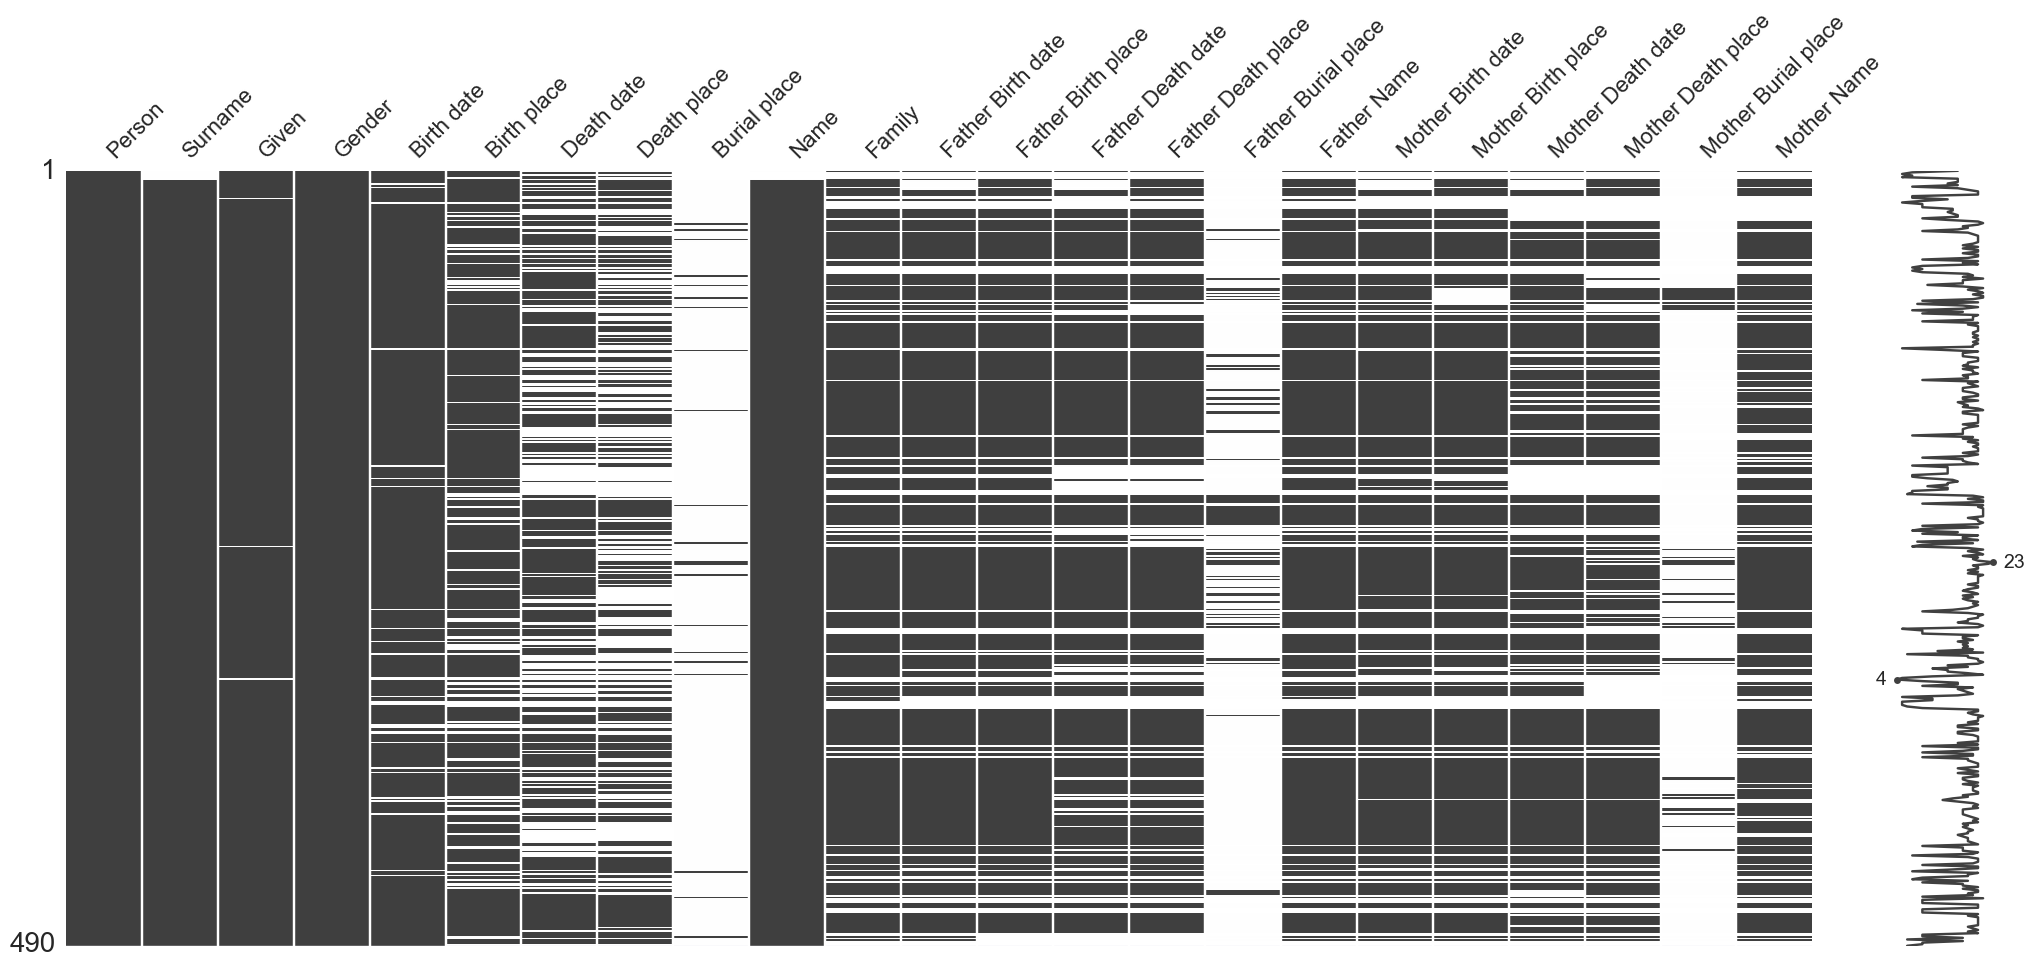

In [9]:
import missingno as msno

msno.matrix(df)

In [10]:
# Renaming columns to remove spaces for dot notation
df.columns = ['PersonKey', 'Surname', 'Given', 'Gender', 'BirthDate', 'BirthPlace', 'DeathDate', 'DeathPlace',
              'BurialPlace', 'Name', 'Family', 'FatherBirthDate', 'FatherBirthPlace', 'FatherDeathDate','FatherDeathPlace',
              'FatherBurialPlace', 'FatherName', 'MotherBirthDate', 'MotherBirthPlace', 'MotherDeathDate', 'MotherDeathPlace',
               'MotherBurialPlace', 'MotherName']

Here's a good look at some more recent data with a couple of great uncles, a great aunt, and my grandpa on my dad's side.  You also can see the recency of my Italian side under the Father/Mother Birth Place columns.

In [11]:
df.ix[304:307]

,PersonKey,Surname,Given,Gender,BirthDate,BirthPlace,DeathDate,DeathPlace,BurialPlace,Name,Family,FatherBirthDate,FatherBirthPlace,FatherDeathDate,FatherDeathPlace,FatherBurialPlace,FatherName,MotherBirthDate,MotherBirthPlace,MotherDeathDate,MotherDeathPlace,MotherBurialPlace,MotherName
304,[P28],Macaluso,Frank,male,1913-11-11,Washington,1999-04-21,"Anderson Island, Pierce, Washington, United St...","Tacoma, Pierce County, Washington, USA",Frank Macaluso,[F0005],1884-04-21,"Alimena, Sicilia, Italy",16 February 1976,"Tacoma, Pierce, Washington, United States of A...",NaN,Joseph Macaluso,1892,Italy,1965-03-03,Tacoma,NaN,Francesca Romano
305,[P9],Macaluso,James Joseph,male,NaN,NaN,about 1969,NaN,NaN,James Joseph Macaluso,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306,[P34],Macaluso,Joseph,male,about 1934,"Tacoma, Pierce County, Washington, USA",NaN,NaN,NaN,Joseph Macaluso,[F0005],1884-04-21,"Alimena, Sicilia, Italy",16 February 1976,"Tacoma, Pierce, Washington, United States of A...",NaN,Joseph Macaluso,1892,Italy,1965-03-03,Tacoma,NaN,Francesca Romano
307,[P30],Macaluso,Mary,female,about 1917,Washington,NaN,NaN,NaN,Mary Macaluso,[F0005],1884-04-21,"Alimena, Sicilia, Italy",16 February 1976,"Tacoma, Pierce, Washington, United States of A...",NaN,Joseph Macaluso,1892,Italy,1965-03-03,Tacoma,NaN,Francesca Romano


# Part II
## The Questions

### Question 1: Family Names

Let's take a quick detour here.  You see the name "Joseph" listed multiple times here, so let's look into family names.  Since this is roughly as far back for records on my dad's side, I know "William" and "Bryan" are very popular on my mom's side.  I'm going to put together a histogram to see what pops up.

I'm going to do this by creating a flattened list out of our given names column to look for *all names* - including middle names.  This will be more of a [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model) approach, as I'm not interested in assigning any kind of weights for middle names. 

In [12]:
# Splitting to account for middle names listed within the 'Given' column
family_names = [str(name).split() for name in df['Given'].dropna()]

# Flattening, removing abbreviations, and transforming into a series to speed things up
family_names = [item for sublist in family_names for item in sublist]
family_names = pd.Series([word if len(word) > 2 else np.NaN for word in family_names]).dropna()

family_names = family_names.value_counts()

# Top 10 names
family_names[:10]

John         36
William      34
Elizabeth    26
Sarah        19
Mary         17
James        16
Thomas       16
Joseph       14
Ann          12
Margaret      9
dtype: int64

So William can definitely be considered a family name, but where is Bryan?  Or am I just biased because that's one of my middle names?

In [13]:
family_names[family_names.index == 'Bryan']

Bryan    4
dtype: int64

Ok, that's a lot lower than I would have thought.  What about the histogram I mentioned?

I'll just use the top 20 names here since there theoretically wouldn't be more than that.

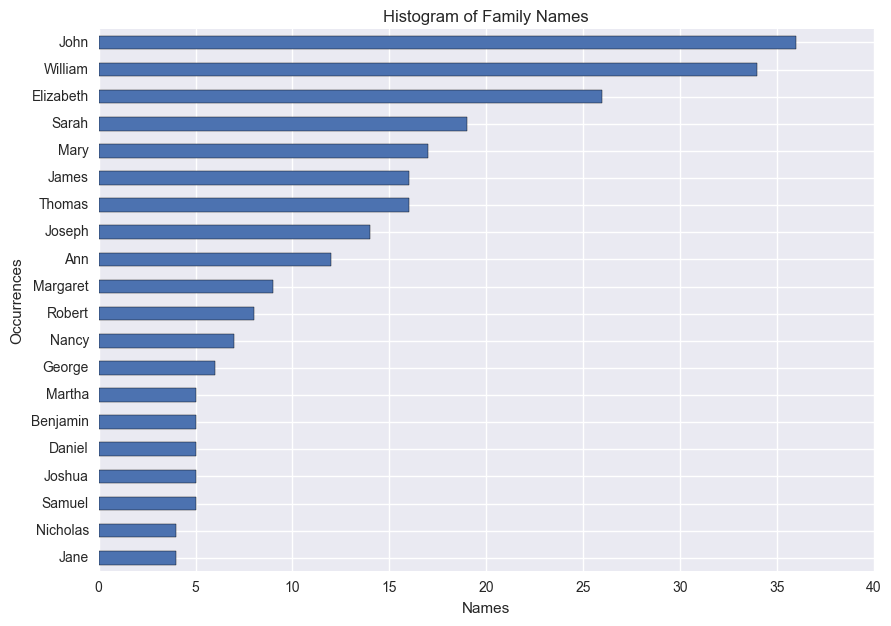

In [14]:
ax = family_names[:20].plot(kind = "barh", figsize = (10, 7), title = "Histogram of Family Names")
ax.set_xlabel("Names")
ax.set_ylabel("Occurrences")

plt.gca().invert_yaxis()  # For descending order

When I initially did this, my data frame contained duplicates, and I saw the name "Keturah" appear with 6 instances.  I have never heard this name in the family before, so I decided to take a look at these records:

In [15]:
df[df['Given'].str.contains("Keturah") == True]

,PersonKey,Surname,Given,Gender,BirthDate,BirthPlace,DeathDate,DeathPlace,BurialPlace,Name,Family,FatherBirthDate,FatherBirthPlace,FatherDeathDate,FatherDeathPlace,FatherBurialPlace,FatherName,MotherBirthDate,MotherBirthPlace,MotherDeathDate,MotherDeathPlace,MotherBurialPlace,MotherName
358,[P363],Peddicord,Keturah,female,1706,"St Annes Parish, Anne Arundel, Maryland, Unite...",1759-12-00,"Baptism St Annes Parish, Anne Arundel, Marylan...",NaN,Keturah Peddicord,[F0056],1669,"Carroll's Manor, Frederick, Maryland, United S...",1732,"Baltimore, Maryland, USA",NaN,John Peddicord,1677,"Elk Ridge, Baltimore, Maryland, United States",1727,"Baltimore, Baltimore, Maryland, United States",NaN,Sarah Dorsey
450,[P415],Shipley,Keturah Roturah,female,1717-11-22,NaN,NaN,NaN,NaN,Keturah Roturah Shipley,[F0066],1726-09-20,"Parish, Anne Arundel, Maryland, USA",1789-06-12,"Shipley Advent, Anne Arundel, Maryland, United...",NaN,George Shipley,1694-01-01,"Ann Arundel Parish, Baltimore, Maryland, Unite...",1762-02-22,"Baltimore, Baltimore, Maryland, United States",NaN,Katherine Ogg


It looks like Keturah is the name of [Abraham's second wife](https://en.wikipedia.org/wiki/Keturah), which I suppose makes sense for ancestors from the colonial times to have that name.

So what about last names?  Mine is out of the running because of the nature of the data, but my mom's maiden name is Johnson, so I'd expect that to have the highest count.

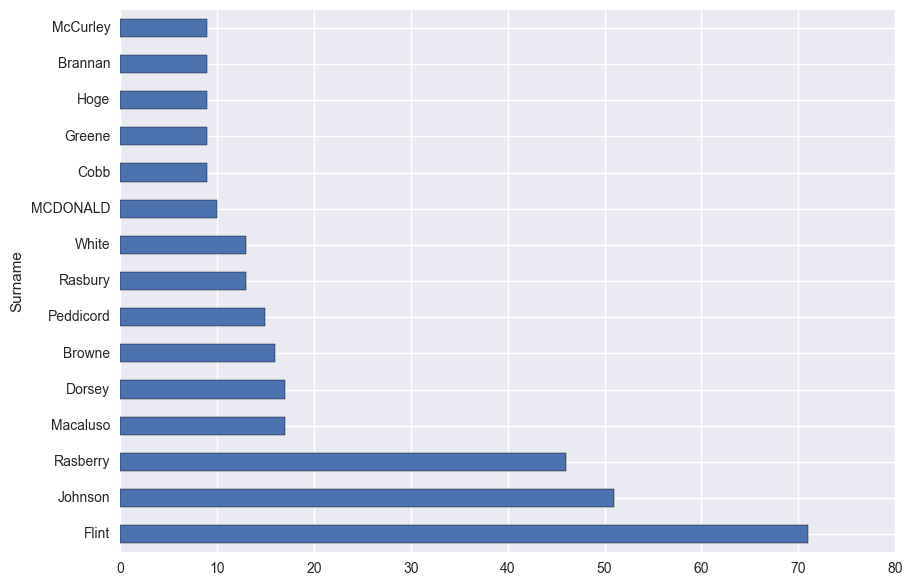

In [16]:
# Frequency of surnames
Surname = df[['Surname', 'PersonKey']].dropna()
Surname = Surname.groupby('Surname').count()
Surname = Surname.sort_values(by = 'PersonKey', ascending = 0)
Surname[:15].plot(kind = 'barh', figsize = (10, 7), legend = False)

I didn't expect to see Flint as higher than Johnson, but I suppose it makes sense since it's my great grandma's maiden name and that line went back to the colonial times.  Rasberry is a similar story, but is my grandma's maiden name.  However, I don't recognize any of the others after my last name.


### Question 2: Mobility Over Time by States

In order to begin with this, we have to clean up our data.  Specifically, we need to extract the state names from our "Birth Place" and "Burial Place" columns.

I'm going to begin by [plugging in a dictionary of US states I found on GitHub](https://gist.github.com/rogerallen/1583593) 

In [17]:
# Creating a dictionary of states and their codes to extract places into states
states = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missisippi': 'MS',  # to account for spelling errors
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

# Reverses the above dictionary to extract state abbreviations using the same function
states_reverse = dict(zip(states.values(),states.keys()))

Now to use the dictionary to pass the individual elements of the column through to check for a match, and extract the state if so.

We'll begin by creating a function that will return a series of the passed column containing the state after using a string split and strip within a list comprehension.

Then, we'll add these series as columns to our dataframe.

Finally, we'll account for instances where a state abbreviation was extracted by converting it to the full state name.

In [18]:
# Extracting the state from various addresses
def state_extract(dict1, dict2, column):
    """
    Extracts the state from the place columns if any part of the record exists 
    within the state dictionary or reverse state dictionary
    
    dict1 is the regular state dictionary, dict2 is the reverse state dictionary for state abbreviations
    """
    return pd.Series([[state.strip() for state in cell.split(',')
               if state.strip() in dict1
                   or state.strip().upper() in dict2]  # dict2 for state abbreviations
              for cell in column.fillna("null")])
    
    
# Running functions to extract the states into series
BirthState = state_extract(states, states_reverse, df['BirthPlace'])
DeathState = state_extract(states, states_reverse, df['DeathPlace'])

FatherBirthState = state_extract(states, states_reverse, df['FatherBirthPlace'])
FatherDeathState = state_extract(states, states_reverse, df['FatherDeathPlace'])

MotherBirthState = state_extract(states, states_reverse, df['MotherBirthPlace'])
MotherDeathState = state_extract(states, states_reverse, df['MotherDeathPlace'])


# Assigns series generated from the function to columns and removes brackets surrounding values
df['BirthState'] = BirthState.apply(lambda s: s[-1] if s else np.NaN)
df['DeathState'] = DeathState.apply(lambda s: s[-1] if s else np.NaN)

df['FatherBirthState'] = FatherBirthState.apply(lambda s: s[-1] if s else np.NaN)
df['FatherDeathState'] = FatherDeathState.apply(lambda s: s[-1] if s else np.NaN)

df['MotherBirthState'] = MotherBirthState.apply(lambda s: s[-1] if s else np.NaN)
df['MotherDeathState'] = MotherDeathState.apply(lambda s: s[-1] if s else np.NaN)


# Converts from abbreviated state to full state name in title case
df['BirthState'] = df['BirthState'].str.upper().replace(states_reverse).str.title()
df['DeathState'] = df['DeathState'].str.upper().replace(states_reverse).str.title()

df['FatherBirthState'] = df['FatherBirthState'].str.upper().replace(states_reverse).str.title()
df['FatherDeathState'] = df['FatherDeathState'].str.upper().replace(states_reverse).str.title()

df['MotherBirthState'] = df['MotherBirthState'].str.upper().replace(states_reverse).str.title()
df['MotherDeathState'] = df['MotherDeathState'].str.upper().replace(states_reverse).str.title()

df[['BirthPlace', 'BirthState', 'DeathPlace', 'DeathState', 'FatherBirthState', 'MotherBirthState']].ix[:3]

,BirthPlace,BirthState,DeathPlace,DeathState,FatherBirthState,MotherBirthState
0,Mississippi,Mississippi,NaN,NaN,Mississippi,Mississippi
1,"South Carolina, USA",South Carolina,"Winston, Mississippi, United States",Mississippi,NaN,NaN
2,",, Sc",South Carolina,NaN,NaN,NaN,NaN
3,"Davie, North Carolina, United States",North Carolina,"St Stephen, Greene, Alabama, United States",Alabama,NaN,NaN


In [19]:
# Adjust for "Missisippi" spelling error
df.replace("Missisippi", "Mississippi", inplace = True)

In [20]:
# Adding abbreviated columns for choropleth maps later
df['BirthStateAbbrev'] = df['BirthState'].replace(states)
df['DeathStateAbbrev'] = df['DeathState'].replace(states)

Here are a couple of quick plots to visualize the birth and death states.  You can see the prominence of Mississippi from my mom's side, and just how recent Texas is in my family's history.

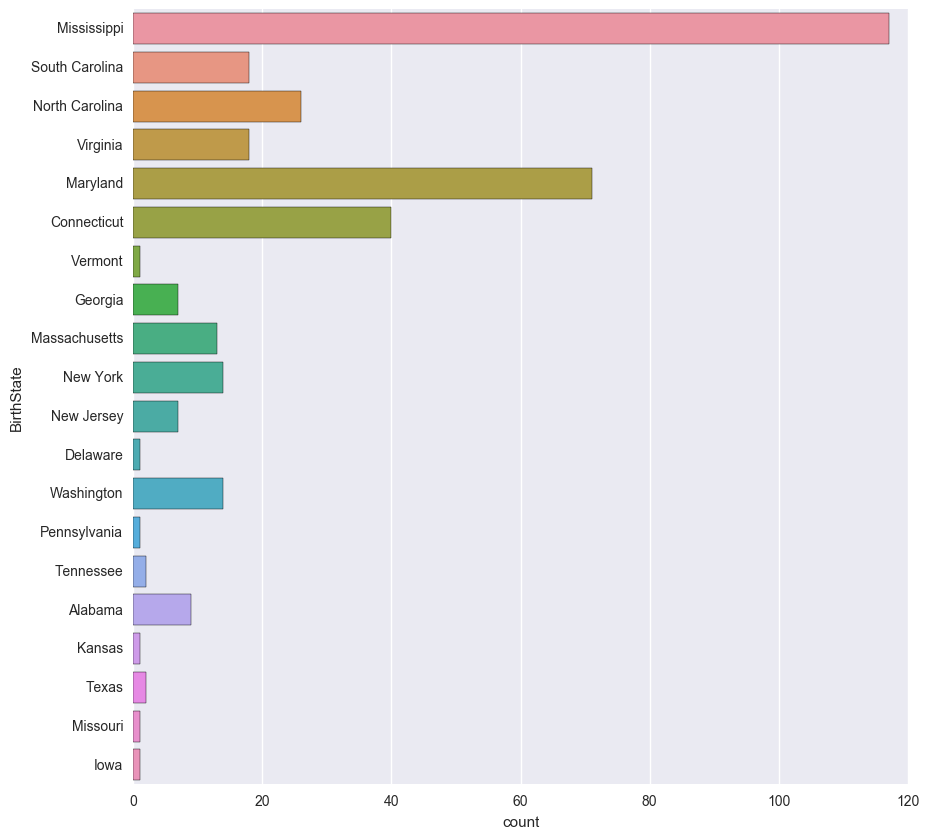

In [21]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(10, 10)
sns.countplot(y = 'BirthState', data = df)

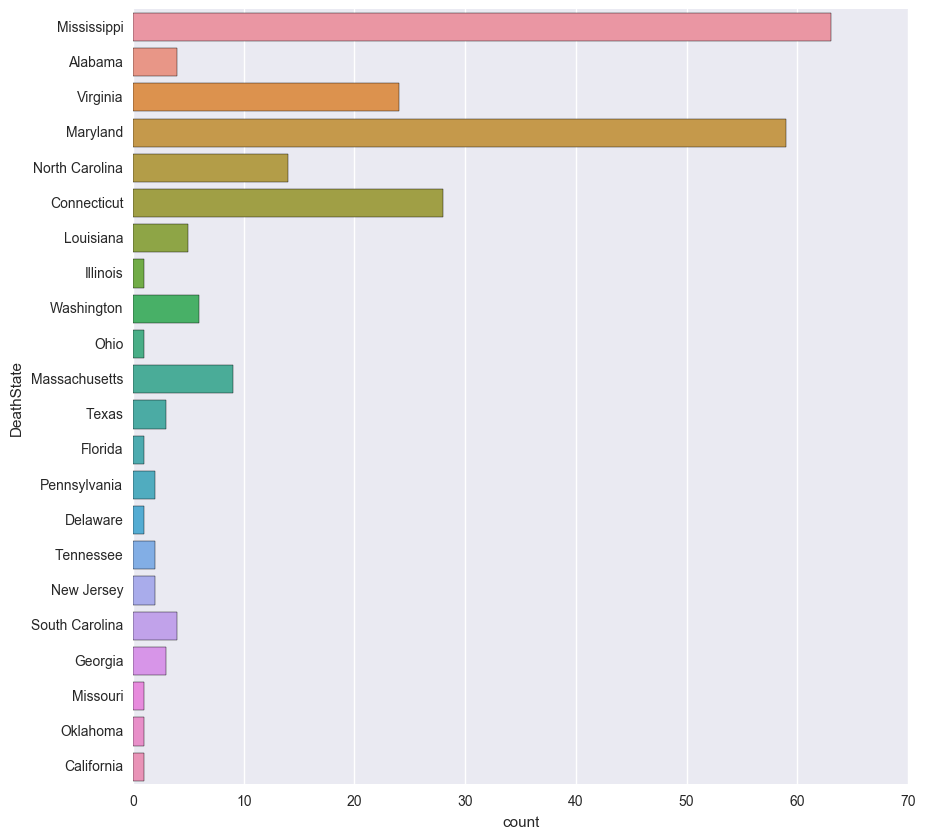

In [22]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(10, 10)
sns.countplot(y = 'DeathState', data = df)

In [23]:
# Creates binary columns to show if the individual died where they were born and if they're currently alive
df['BirthState'].fillna(np.NaN)
df['DiedWhereBorn'] = np.where(df['BirthState'] == df['DeathState'], 1, np.where(df['DeathState'].isnull(), np.NaN, 0))  # Also add NaN
df['IsAlive'] = np.where(df['DeathPlace'].notnull() == True, 1, np.where(df['BirthState'].isnull(), np.NaN, 0))

In [24]:
# Creates binary columns for if the individual was born in their mother or father's states.  Will be used to calculate mobility
df['BornInFatherState'] = np.where(df['BirthState'] == df['FatherBirthState'], 1, np.where(df['FatherBirthState'].isnull(), np.NaN, 0))
df['BornInMotherState'] = np.where(df['BirthState'] == df['MotherBirthState'], 1, np.where(df['MotherBirthState'].isnull(), np.NaN, 0))

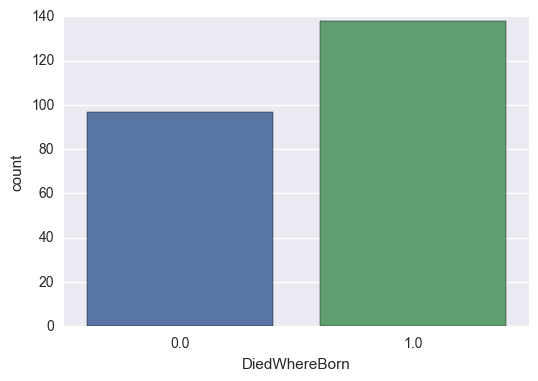

In [25]:
fig, ax = plt.subplots()

sns.countplot(x = 'DiedWhereBorn', data = df)

I checked unique values after extracting the United States out of all birth place columns and filtered them to not include it to check if this dictionary contained everything.  This list ended up being more comprehensive, but I left it for future use for other GEDCOM files

In [26]:
countries = {
    # Europe
    'England': 'EN',
    'Scotland': 'SC',
    'Wales': 'WL',
    'Ireland': 'IR',
    'Rebpulic of Ireland': 'IR',
    'Great Britain': 'GB',
    'Britain': 'GB',
    'United Kingdom': 'UK',
    'Italy': 'IT',
    'ITA': 'IT',
    'Germany': 'DE',
    'France': 'FR',
    'Denmark': 'DR',
    'Sweden': 'SW',
    'Norway': 'NR',
    'Canada': 'CN',
    'Netherlands': 'ND',
    'Spain': 'SP',
    'Belgium': 'BG',
    'Poland': 'PL',
    'Austria': 'AR',
    'Portugal': 'PR',
    'Russia': 'RU',
    'Hungary': 'HR',
    'Slovakia': 'SL',
    'Greece': 'GR',
    
    # North America
    'United States': 'US',
    'USA': 'US',
    'US': 'US',
    'Mexico': 'MX'
}

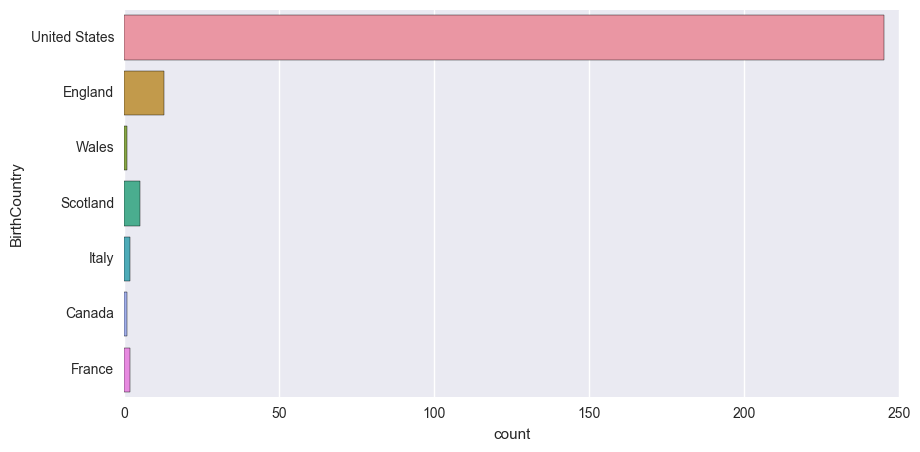

In [27]:
# Extracting the country from birth addresses
BirthCountry = pd.Series([[state.strip() for state in cell.split(',') 
                  if state.strip() in countries] 
                 for cell in df.BirthPlace.fillna("null")])

df['BirthCountry'] = BirthCountry.apply(lambda s: s[-1] if s else np.NaN)
df['BirthCountry'] = np.where(df['BirthCountry'] == 'USA', 'United States', df['BirthCountry'])

fig, ax = plt.subplots()

fig.set_size_inches(10, 5)
sns.countplot(y = 'BirthCountry', data = df)

In [28]:
# Binning the birth years into decades

Years_int = np.arange(1500, 2020)  # To extract the birth and death years
Years = [str(s) for s in Years_int]  # Changes the data type to a string to scan the column


decades = np.arange(1600, 2020, 10)
decades_labels = [(str(s)+"'s") for s in decades]  # Changes the data type to a string to scan the column
del decades_labels[-1]  # Removes the last record to use as the labels in the pd.cut



# Extracting the birth year from the date
BirthYear = pd.Series([[date.strip() for date in cell.split(' ')
                  if date.strip() in Years]
                 for cell in df['BirthDate'].fillna("null").str.replace('-', ' ')])

# Applying the bins
df['BirthYear'] = BirthYear.apply(lambda s: s[-1] if s else np.NaN)
df['BirthYear'] = pd.to_numeric(df['BirthYear'])
df['BirthDecade'] = pd.cut(df['BirthYear'], decades, labels = decades_labels)


# Extracting the death year from the date
DeathYear = pd.Series([[date.strip() for date in cell.split(' ')
                  if date.strip() in Years]
                 for cell in df['DeathDate'].fillna("null").str.replace('-', ' ')])

# Appending to the data frame as a numeric column
df['DeathYear'] = DeathYear.apply(lambda s: s[-1] if s else np.NaN)
df['DeathYear'] = pd.to_numeric(df['DeathYear'])

df[['BirthDate', 'BirthYear', 'BirthDecade', 'DeathDate', 'DeathYear']].head()

,BirthDate,BirthYear,BirthDecade,DeathDate,DeathYear
0,1894,1894.0,1890's,NaN,NaN
1,1810,1810.0,1800's,1853,1853.0
2,1795,1795.0,1790's,NaN,NaN
3,1772,1772.0,1770's,1841,1841.0
4,1759,1759.0,1750's,1808,1808.0


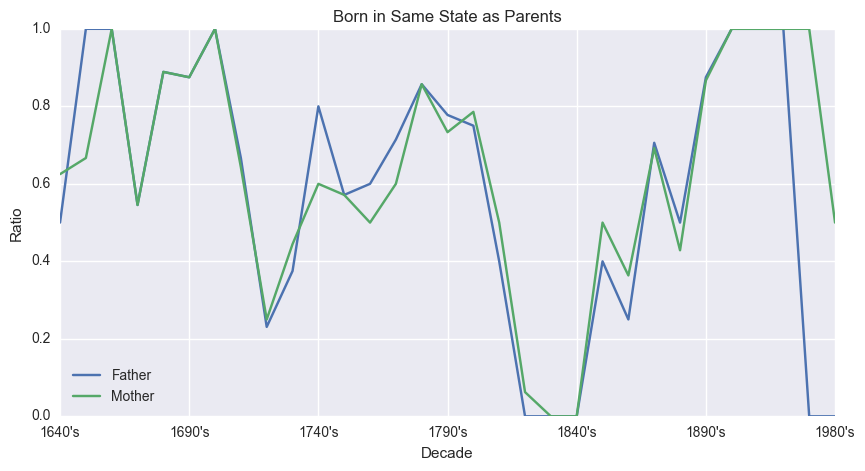

In [29]:
# Calculating ratios to view mobility of generations
born_in_father_state_ratio = df['BornInFatherState'].groupby(df['BirthDecade']).mean()
born_in_mother_state_ratio = df['BornInMotherState'].groupby(df['BirthDecade']).mean()

BirthRatio = pd.concat([born_in_father_state_ratio, born_in_mother_state_ratio], axis=1)
BirthRatio.columns = ['Father', 'Mother']

ax = BirthRatio.dropna().plot(title = "Born in Same State as Parents", figsize = (10, 5))
ax.set_ylabel("Ratio")
ax.set_xlabel("Decade")

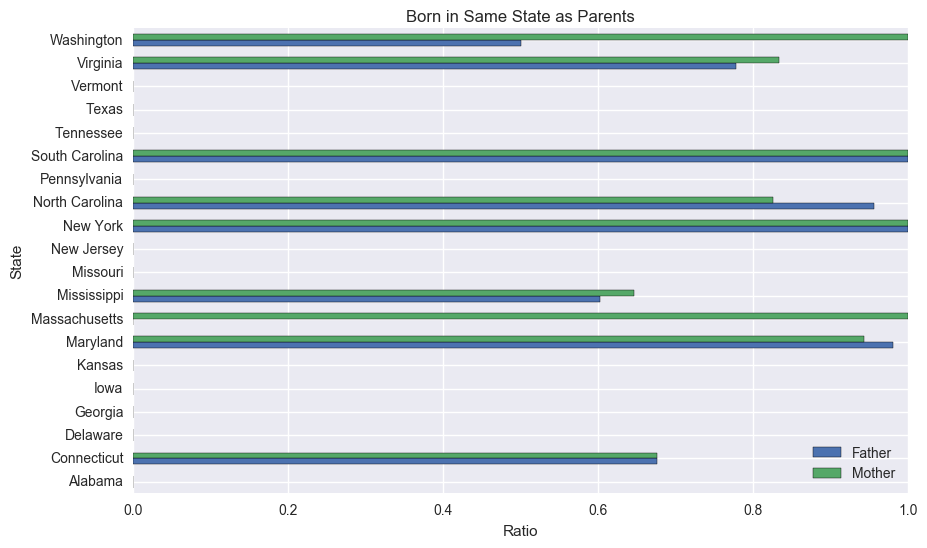

In [30]:
FatherStateBirthRatio = df['BornInFatherState'].groupby(df['BirthState']).mean()
MotherStateBirthRatio = df['BornInMotherState'].groupby(df['BirthState']).mean()

BirthRatioByState = pd.concat([FatherStateBirthRatio, MotherStateBirthRatio], axis=1)
BirthRatioByState.columns = ['Father', 'Mother']
ax = BirthRatioByState.plot(kind = "barh", figsize = (10, 6), title = "Born in Same State as Parents")
ax.set_xlabel("Ratio")
ax.set_ylabel("State")

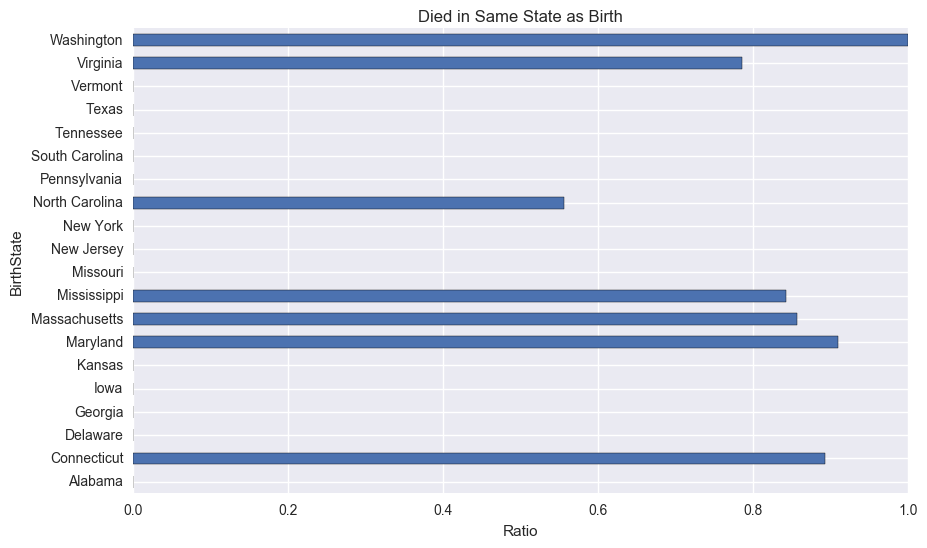

In [31]:
DiedWhereBornRatio = df['DiedWhereBorn'].groupby(df['BirthState']).mean()
DiedWhereBornRatio.plot(kind="barh", figsize=(10, 6), 
                        title="Died in Same State as Birth").set_xlabel("Ratio")

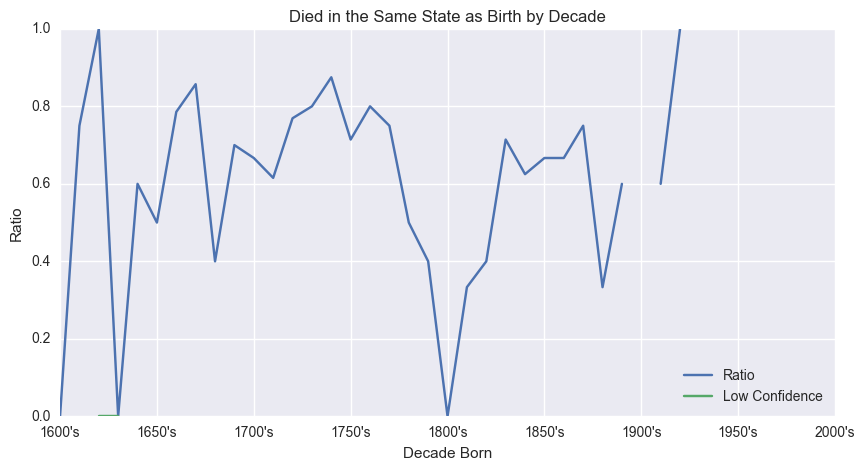

In [32]:
# To examine the trend of mobility by decade by ratios of population that died in the same state they were born in
died_where_born_ratio = df['DiedWhereBorn'].groupby(df['BirthDecade']).mean()
died_where_born_population = df['DiedWhereBorn'].groupby(df['BirthDecade']).count()  # To be used in the confidence
died_where_born = pd.concat([died_where_born_ratio, died_where_born_population], axis=1)
died_where_born.columns = ['Ratio', 'Confidence']

# Assigns a normalized "confidence" score based off of the population
died_where_born['Confidence'] -= died_where_born['Confidence'].min()
died_where_born['Confidence'] /= died_where_born['Confidence'].max()
# A "Low Confidence" bucket for the plot
died_where_born['Low Confidence'] = np.where(died_where_born['Confidence'] < 0.25, 0, np.NaN)
died_where_born['Low Confidence'] = np.where(died_where_born['Ratio'].isnull(), np.NaN, died_where_born['Low Confidence'])
died_where_born.drop(['Confidence'], axis = 1, inplace = True)


# sns.tsplot(data=died_where_born_ratio, xlab)
ax = died_where_born.plot(title = "Died in the Same State as Birth by Decade",
                     figsize = (10, 5))
ax.set_ylabel("Ratio")
ax.set_xlabel("Decade Born")

## Trends over Time

The time series plots gave us a decent picture of these concepts, but let's look at some linear model plots to get a clear picture of trends over time.  We'll be using [Seaborn's linear model plots](https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.lmplot.html) which create an ordinary least squares line with 95% confidence intervals.

Let's start with a linear plot of the ratio of people died where born by decade:

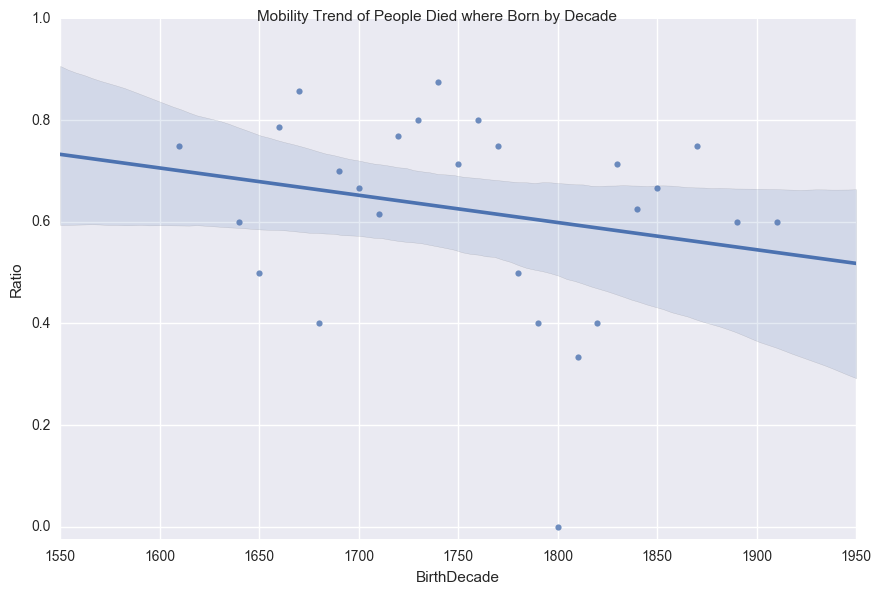

In [33]:
died_where_born_linear = died_where_born.reset_index()
died_where_born_linear['Low Confidence'].replace(0, 1, inplace=True)
died_where_born_linear['Low Confidence'].fillna(0, inplace=True)
died_where_born_linear.dropna(inplace = True)

died_where_born_linear['BirthDecade'] = died_where_born_linear['BirthDecade'].str.strip("'s")
died_where_born_linear['BirthDecade'] = died_where_born_linear['BirthDecade'].astype(int)
ax = sns.lmplot(x="BirthDecade", y="Ratio",
                data = died_where_born_linear[died_where_born_linear['Low Confidence'] == 0],
               size=6, aspect=1.5)  # Similar size to plt.figure(figsize=(10, 5))
ax.fig.suptitle('Mobility Trend of People Died where Born by Decade', size = 11)
ax.set(ylim=(-0.025, 1.0))

So this indicates a shift towards increased mobility over time, e.g. people more frequently spending their final days in a different state than the one they were born in as we get closer to the modern day.

So if that's mobility over their entire lifetime, let's take a look at a slice in the people's lives.  Since the only reliable geographical data points we have are birth places and death places, let's compare the state children are born in with that of their parents:

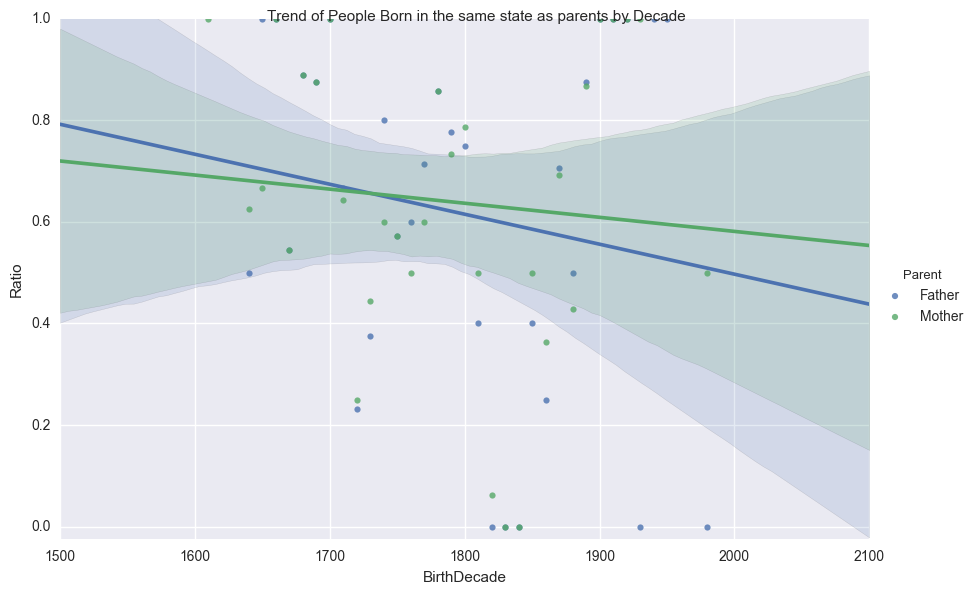

In [34]:
# Split our data between mother and father to create our flags
birth_ratio_linear = BirthRatio
linear_father = birth_ratio_linear[['Father']]
linear_father.columns = ['Ratio']
linear_father['Parent'] = 'Father'

linear_mother = birth_ratio_linear[['Mother']]
linear_mother.columns = ['Ratio']
linear_mother['Parent'] = 'Mother'

# Recombine, drop NA, 
birth_ratio_linear = linear_father.append(linear_mother)
birth_ratio_linear.dropna(inplace=True)
birth_ratio_linear.reset_index(inplace=True)

# Convert the decades to integers to allow the linear plot to work properly
birth_ratio_linear['BirthDecade'] = birth_ratio_linear['BirthDecade'].str.strip("'s")
birth_ratio_linear['BirthDecade'] = birth_ratio_linear['BirthDecade'].astype(int)

ax = sns.lmplot(x="BirthDecade", y="Ratio", hue='Parent',
                data=birth_ratio_linear,
               size=6, aspect=1.5)  # Similar size to plt.figure(figsize=(10, 5))
ax.fig.suptitle('Trend of People Born in the same state as parents by Decade', size=11)
ax.set(ylim=(-0.025, 1.0))

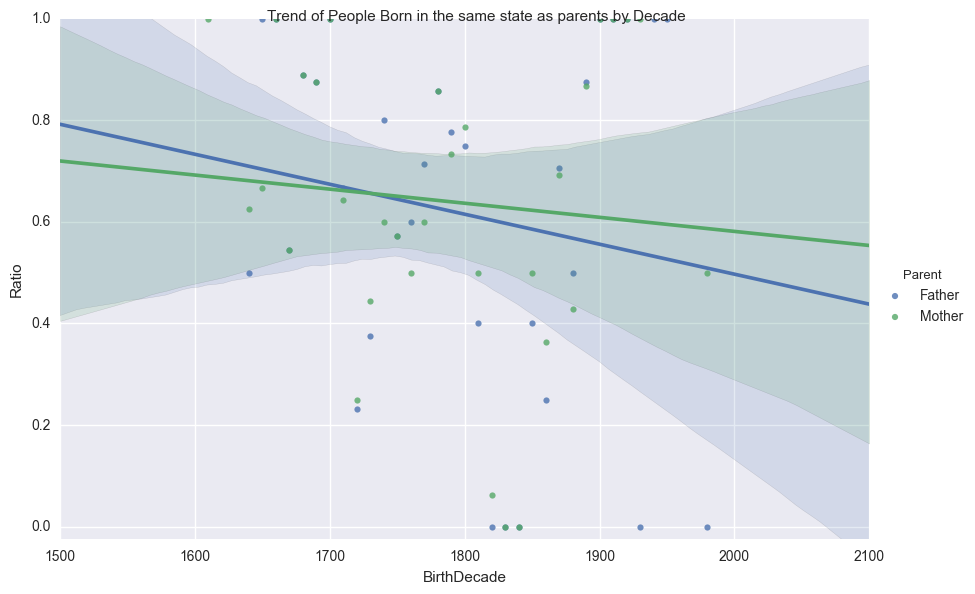

In [35]:
# Split our data between mother and father to create our flags
birth_ratio_linear = BirthRatio
linear_father = birth_ratio_linear[['Father']]
linear_father.columns = ['Ratio']
linear_father['Parent'] = 'Father'

linear_mother = birth_ratio_linear[['Mother']]
linear_mother.columns = ['Ratio']
linear_mother['Parent'] = 'Mother'

# Recombine, drop NA, 
birth_ratio_linear = linear_father.append(linear_mother)
birth_ratio_linear.dropna(inplace=True)
birth_ratio_linear.reset_index(inplace=True)

# Convert the decades to integers to allow the linear plot to work properly
birth_ratio_linear['BirthDecade'] = birth_ratio_linear['BirthDecade'].str.strip("'s")
birth_ratio_linear['BirthDecade'] = birth_ratio_linear['BirthDecade'].astype(int)

ax = sns.lmplot(x="BirthDecade", y="Ratio", hue='Parent',
                data=birth_ratio_linear,
               size=6, aspect=1.5)  # Similar size to plt.figure(figsize=(10, 5))
ax.fig.suptitle('Trend of People Born in the same state as parents by Decade', size=11)
ax.set(ylim=(-0.025, 1.0))

We can also see this decreasing over time, and the trend for the ratio of children born in the same state as their father decreases over time.  Is this because of men moving more frequently for work?

That's possible, but in reality, a linear fit is a bad choice in our example above.  Our massive confidence intervals should be a dead give away, and while seaborn doesn't output an $R^2$, you could [guess that it'd be terrible](http://guessthecorrelation.com/). However, let's do a residual plot for fun:

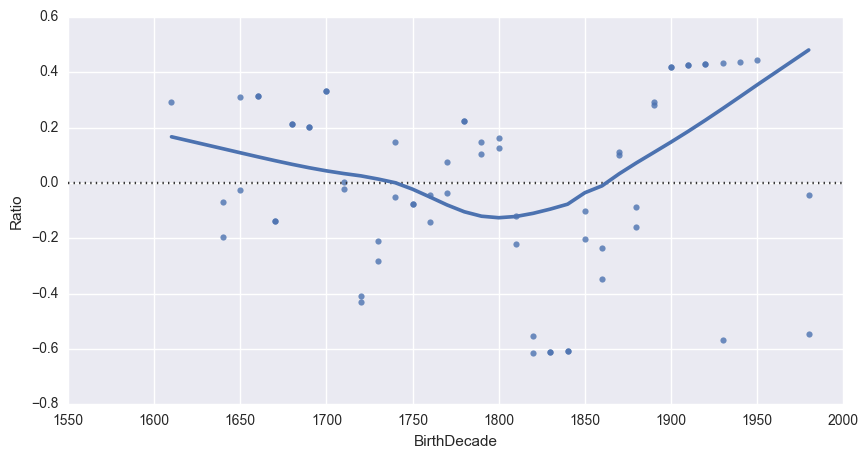

In [36]:
plt.figure(figsize=(10, 5))
sns.residplot('BirthDecade', 'Ratio', data = birth_ratio_linear, lowess=True)

Yep, that's a terrible fit.  

Basically, the main thing going on here is that we have a lot of outliers due to a handful of decades having a ratio of 0.  In order to more accurately capture the trend, we should smooth this out by expanding our bins.

In [37]:
# Using static year instead of datetime.date.today().year since data is static
df['LifeSpan'] = df['DeathYear'] - df['BirthYear']

df['CurrentAge'] = (df[(df['DeathYear'].isnull()) & 
                      (df['BirthYear'] >= (2016-100))].DeathYear.fillna(2016) 
                   - 
                   df[(df['DeathYear'].isnull()) & 
                      (df['BirthYear'] >= (2016-115))].BirthYear)

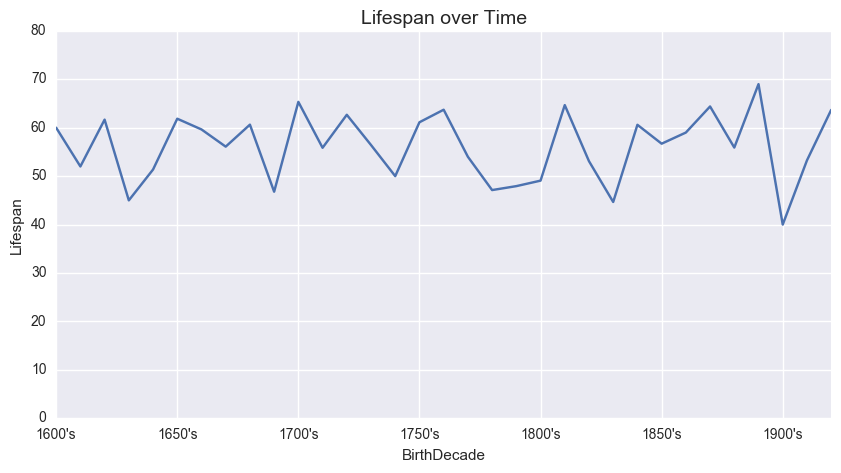

In [38]:
lifespan = df[df['LifeSpan'].isnull() == False][['LifeSpan', 'BirthDecade']]
avg_lifespan_decade = lifespan['LifeSpan'].groupby(lifespan['BirthDecade']).mean()
avg_lifespan_decade = avg_lifespan_decade.dropna()[:-1]  # Removing the last record to prevent skew

ax = avg_lifespan_decade.plot(figsize=(10, 5))
ax.set_ylim([0,80])
ax.set_ylabel("Lifespan")
ax.set_title("Lifespan over Time", fontsize=14)

Since we can't observe obvious trends from that plot, let's discretize our birth years further in order to smooth it out.  Let's do every 30 years:

In [39]:
thirty_year_bins = np.arange(1600, 2020, 30)
thirty_year_labels = [(str(s)+"'s") for s in thirty_year_bins]  # Changes the data type to a string to scan the column
del thirty_year_labels[-1]  # Removes the last record to use as the labels in the pd.cut

# Applying the bins
df['BirthBin'] = pd.cut(df['BirthYear'], thirty_year_bins, labels = thirty_year_labels)

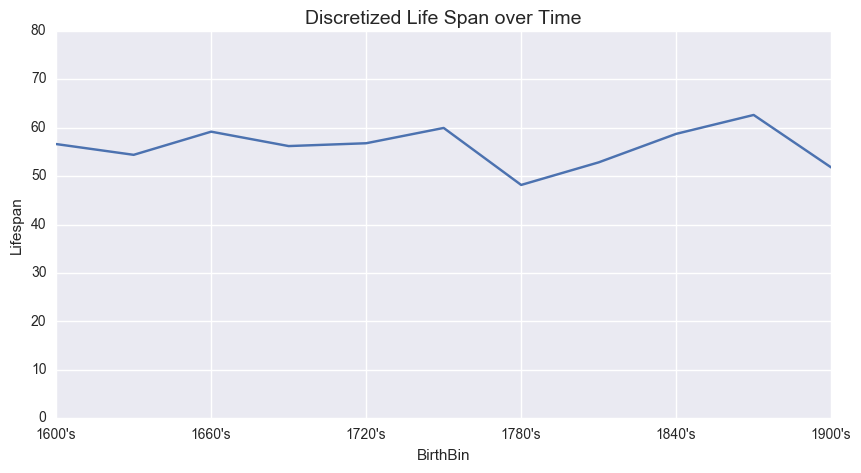

In [40]:
lifespan = df[df['LifeSpan'].isnull() == False][['LifeSpan', 'BirthBin']]
avg_lifespan_thirty_years = lifespan['LifeSpan'].groupby(lifespan['BirthBin']).mean()
avg_lifespan_thirty_years = avg_lifespan_thirty_years.dropna()[:-1]

ax = avg_lifespan_thirty_years.plot(figsize=(10, 5))
ax.set_ylim([0,80])
ax.set_ylabel("Lifespan")
ax.set_title("Discretized Life Span over Time", fontsize=14)

Surprisingly, there isn't a gradual trend upward like you would expect.  That being said, most charts you see (like the one below) often start in the 20th century, which is where most modern medicine advancements were made (namely the discovery of [penecilin](https://en.wikipedia.org/wiki/Penicillin) in 1928).

<img src="http://www.worldclimatereport.com/wp-images/life_expectancy_2009.JPG">

Note that the dip you see in 1918 is from the [Spanish flu pandemic](https://en.wikipedia.org/wiki/1918_flu_pandemic) that had a devastating effect on the world population.

## Choropleth maps

https://github.com/Prooffreader/chorogrid

http://prooffreaderplus.blogspot.com/2015/08/a-python-script-to-make-choropleth-grid.html

In [41]:
def mapLegendScale(column):
    """
    Returns a list of values to discretize the legend in the choropleth maps
    """
    maxVal = column.max()
    legend = [int(x) for x in list(np.arange(0, maxVal+1, maxVal/6))]
    return legend

def mapLegendScaleMinStart(column):
    """
    Returns a list of values to discretize the legend in the choropleth maps
    
    Starts with the minimum rather than 0
    """
    maxVal = column.max()
    minVal = column.min()
    legend = [int(x) for x in list(np.arange(minVal, maxVal+1, (maxVal-minVal)/6))]
    return legend

In [42]:
# http://bsou.io/posts/color-gradients-with-python

def hex_to_RGB(hex):
  ''' "#FFFFFF" -> [255,255,255] '''
  # Pass 16 to the integer function for change of base
  return [int(hex[i:i+2], 16) for i in range(1,6,2)]

def RGB_to_hex(RGB):
  ''' [255,255,255] -> "#FFFFFF" '''
  # Components need to be integers for hex to make sense
  RGB = [int(x) for x in RGB]
  return "#"+"".join(["0{0:x}".format(v) if v < 16 else
            "{0:x}".format(v) for v in RGB])

def color_dict(gradient):
  ''' Takes in a list of RGB sub-lists and returns dictionary of
    colors in RGB and hex form for use in a graphing function
    defined later on '''
  return {"hex":[RGB_to_hex(RGB) for RGB in gradient],
      "r":[RGB[0] for RGB in gradient],
      "g":[RGB[1] for RGB in gradient],
      "b":[RGB[2] for RGB in gradient]}

def linear_gradient(start_hex, finish_hex="#FFFFFF", n=10):
  ''' returns a gradient list of (n) colors between
    two hex colors. start_hex and finish_hex
    should be the full six-digit color string,
    inlcuding the number sign ("#FFFFFF") '''
  # Starting and ending colors in RGB form
  s = hex_to_RGB(start_hex)
  f = hex_to_RGB(finish_hex)
  # Initilize a list of the output colors with the starting color
  RGB_list = [s]
  # Calcuate a color at each evenly spaced value of t from 1 to n
  for t in range(1, n):
    # Interpolate RGB vector for color at the current value of t
    curr_vector = [
      int(s[j] + (float(t)/(n-1))*(f[j]-s[j]))
      for j in range(3)
    ]
    # Add it to our list of output colors
    RGB_list.append(curr_vector)

  return color_dict(RGB_list)

mapGreen = linear_gradient('#bfe0be', '#2a6828', 6)['hex']
mapRed = linear_gradient('#e59292', '#5b0505', 6)['hex']
mapBlue = linear_gradient('#3ca9f2', '#2c3e50', 6)['hex']
mapPurple = linear_gradient('#c295d8', '#5f018e', 6)['hex']

In [43]:
def createMapUSA(column, colors, title, legendTitle, legendScaleMin=0):
    """
    Creates and plots a choropleth map for the USA based off of the given inputs
    
    Must come from the usaMap data frame
    """
    # Creating the color bin per the chorogrid documentation
    mapBin = Colorbin(usaMap[column], colors, proportional=True, decimals=None)
    
    # Creates the intervals for the legend using the previously defined functions
    # Will use the appropriate function given the input
    if legendScaleMin == 1:
        mapBin.fenceposts = mapLegendScaleMinStart(usaMap[column])
    else:
        mapBin.fenceposts = mapLegendScale(usaMap[column])
        if legendScaleMin != 0:
            print('Warning: Expecting binary input.  Assuming 0.')
    mapBin.recalc(False)
    
    # Applies colors to the states
    statesMap = list(usaMap.dropna(subset=[column]).State)
    colors_by_state = mapBin.colors_out
    font_colors_by_state = mapBin.complements
    legend_colors = mapBin.colors_in
    legend_labels = mapBin.labels
    
    # Creates the actual plot
    cg = Chorogrid('usa_states.csv', statesMap, colors_by_state)
    cg.set_title(title)
    cg.set_legend(mapBin.colors_in, mapBin.labels, title=legendTitle)
    cg.draw_map(spacing_dict={'legend_offset': [-275, -200]})
    cg.done(show=True)

In [44]:
# Creating one dataframe for the USA maps from different groupbys
birthStates = df['PersonKey'].groupby(df['BirthStateAbbrev']).count()
birthStates = birthStates.reset_index()
birthStates.columns = ['State', 'BirthCount']  # Renaming for the merge

deathStates = df['PersonKey'].groupby(df['DeathStateAbbrev']).count()
deathStates = deathStates.reset_index()
deathStates.columns = ['State', 'DeathCount']  # Renaming for the merge

timeStates = df['BirthYear'].groupby(df['BirthStateAbbrev']).mean()
timeStates = timeStates.reset_index()
timeStates.columns = ['State', 'AvgYearBorn']  # Renaming for the merge

lifeSpanStates = df['LifeSpan'].groupby(df['BirthStateAbbrev']).mean().dropna()
lifeSpanStates = lifeSpanStates.reset_index()
lifeSpanStates.columns = ['State', 'AvgLifeSpan']  # Renaming for the merge


# Gathering a percentage of residents from the state that moved
staticStates = df[df['DiedWhereBorn'] == 1]['PersonKey'].groupby(df['BirthStateAbbrev']).count() \
    / df['PersonKey'].groupby(df['BirthStateAbbrev']).count() * 100
staticStates = staticStates.reset_index()
staticStates.columns = ['State', 'DiedWhereBornPct']  # Renaming for the merge

emigratedFromStates = df[df['DiedWhereBorn'] == 0]['PersonKey'].groupby(df['BirthStateAbbrev']).count() \
    / df['PersonKey'].groupby(df['BirthStateAbbrev']).count() * 100
emigratedFromStates = emigratedFromStates.reset_index()
emigratedFromStates.columns = ['State', 'EmigratedPct']

immigratedFromStates = df[df['DiedWhereBorn'] == 0]['PersonKey'].groupby(df['DeathStateAbbrev']).count()
immigratedFromStates = immigratedFromStates.reset_index()
immigratedFromStates.columns = ['State', 'ImmigratedCount']


usaMap = pd.merge(birthStates, deathStates, how='outer')
usaMap = usaMap.merge(staticStates, how='outer').merge(timeStates, how='outer') \
               .merge(lifeSpanStates, how='outer').merge(emigratedFromStates, how='outer') \
               .merge(immigratedFromStates, how='outer')

# Applying percentages to normalize our maps
usaMap['BirthPct'] = usaMap['BirthCount']/usaMap['BirthCount'].sum() * 100
usaMap['DeathPct'] = usaMap['DeathCount']/usaMap['DeathCount'].sum() * 100

usaMap

,State,BirthCount,DeathCount,DiedWhereBornPct,AvgYearBorn,AvgLifeSpan,EmigratedPct,ImmigratedCount,BirthPct,DeathPct
0,AL,9.0,4.0,NaN,1832.777778,56.000000,66.666667,4.0,2.472527,1.702128
1,CT,40.0,28.0,62.500000,1727.025000,51.250000,7.500000,3.0,10.989011,11.914894
2,DE,1.0,1.0,NaN,1675.000000,70.000000,100.000000,1.0,0.274725,0.425532
3,GA,7.0,3.0,NaN,1793.857143,62.800000,71.428571,3.0,1.923077,1.276596
4,IA,1.0,NaN,NaN,1735.000000,41.000000,100.000000,NaN,0.274725,NaN
5,KS,1.0,NaN,NaN,1990.000000,NaN,NaN,NaN,0.274725,NaN
6,MA,13.0,9.0,46.153846,1682.769231,64.333333,7.692308,3.0,3.571429,3.829787
7,MD,71.0,59.0,70.422535,1717.816901,50.492063,7.042254,9.0,19.505495,25.106383
8,MO,1.0,1.0,NaN,1891.000000,NaN,100.000000,1.0,0.274725,0.425532
9,MS,117.0,63.0,27.350427,1874.732759,52.836066,5.128205,31.0,32.142857,26.808511


In [45]:
df[df['DiedWhereBorn'] == 0]['PersonKey'].groupby(df['BirthStateAbbrev']).count() \
    / df['PersonKey'].groupby(df['BirthStateAbbrev']).count() * 100

BirthStateAbbrev
AL     66.666667
CT      7.500000
DE    100.000000
GA     71.428571
IA    100.000000
KS           NaN
MA      7.692308
MD      7.042254
MO    100.000000
MS      5.128205
NC     30.769231
NJ    100.000000
NY      7.142857
PA           NaN
SC     72.222222
TN     50.000000
TX           NaN
VA     16.666667
VT           NaN
WA           NaN
Name: PersonKey, dtype: float64

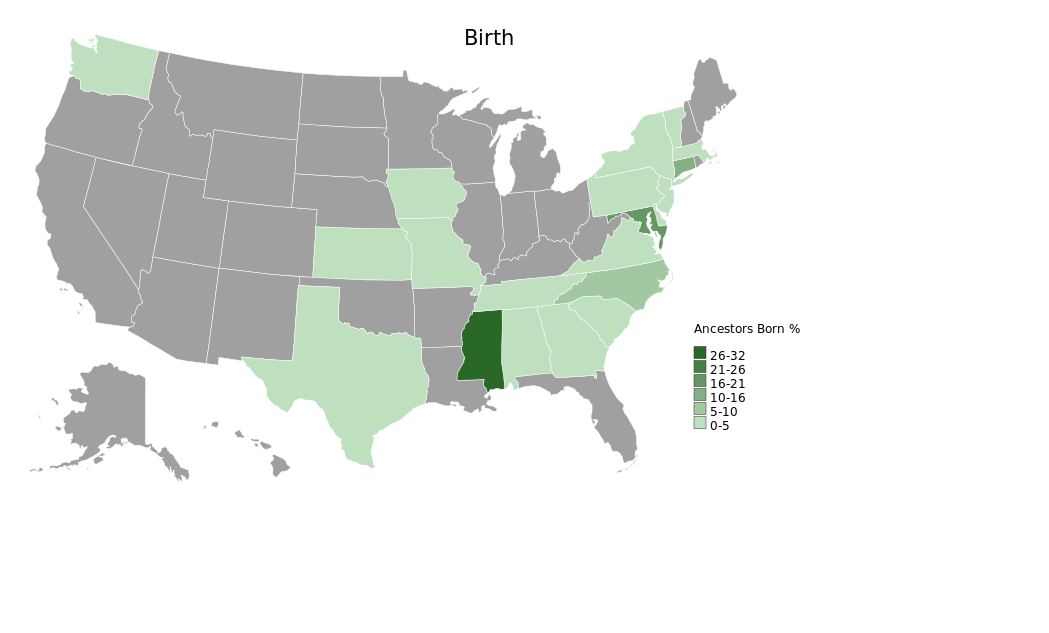

In [46]:
createMapUSA('BirthPct',  # Column to plot
             mapGreen,  # Colors to use
             'Birth',  # Title
             'Ancestors Born %',  # Legend Title
             legendScaleMin=0)  # Binary for if the lowest value should be the min value or 0

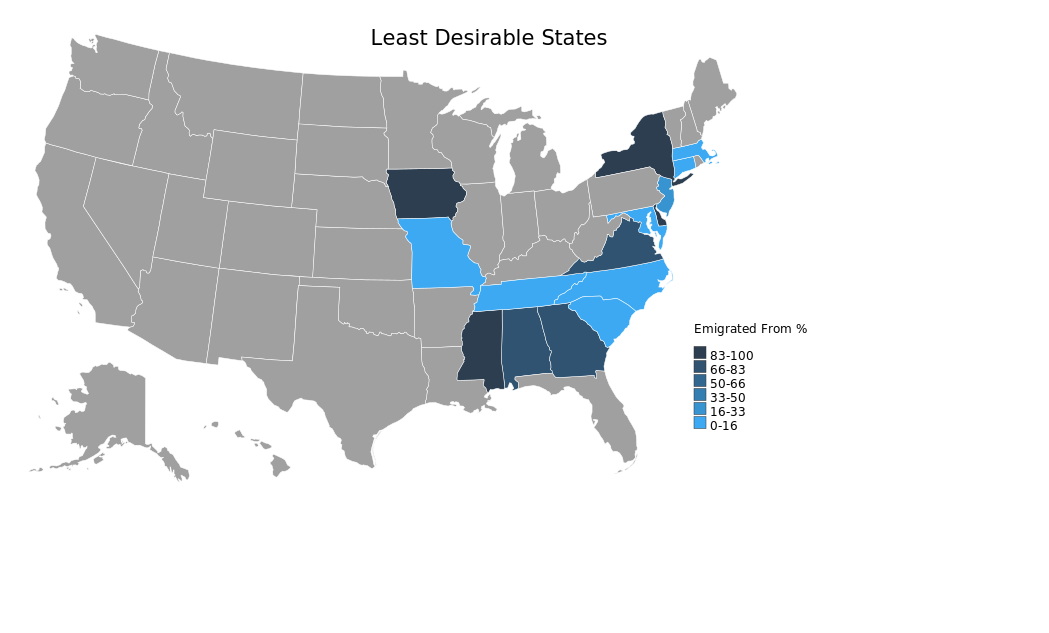

In [47]:
createMapUSA('EmigratedPct',  # Column to plot
             mapBlue,  # Colors to use
             'Least Desirable States',  # Title
             'Emigrated From %',  # Legend Title
             legendScaleMin=0)  # Binary for if the lowest value should be the min value or 0

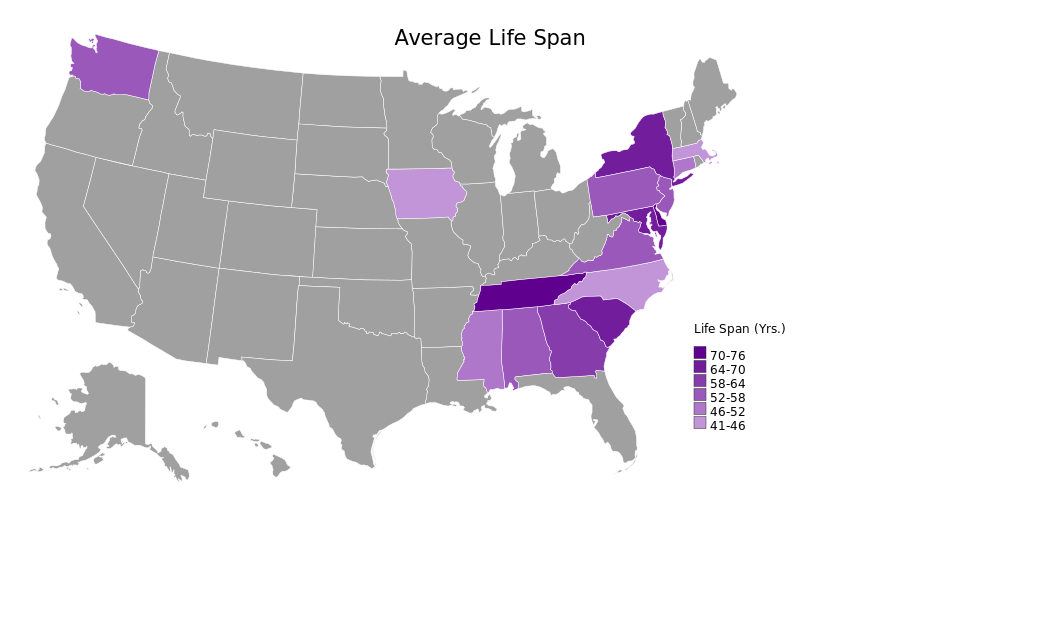

In [48]:
createMapUSA('AvgLifeSpan',  # Column to plot
             mapPurple,  # Colors to use
             'Average Life Span',  # Title
             'Life Span (Yrs.)',  # Legend Title
             legendScaleMin=1)  # Binary for if the lowest value should be the min value or 0

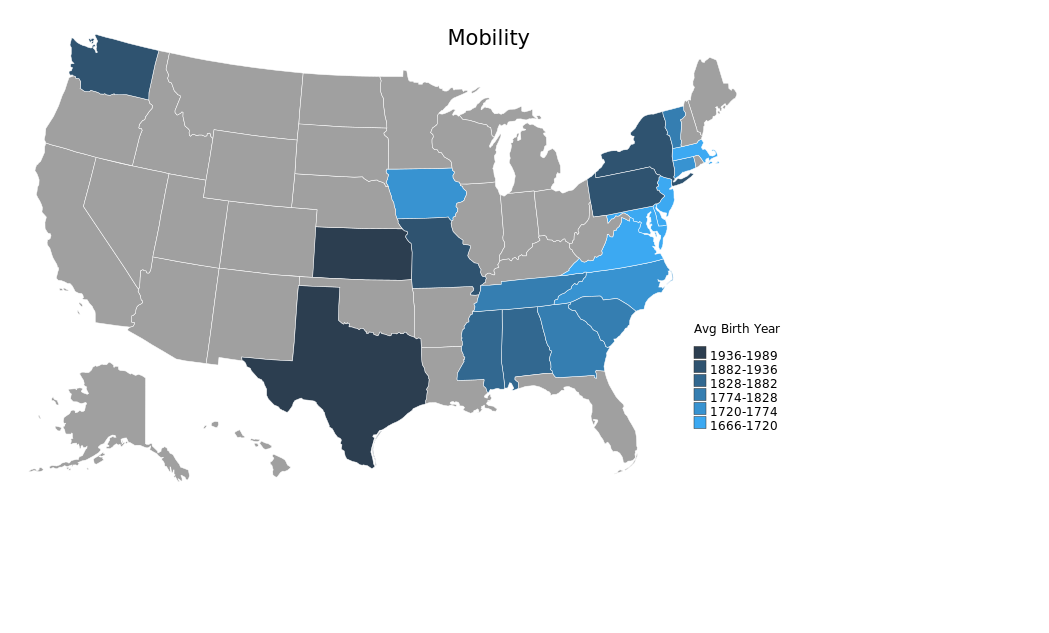

In [49]:
createMapUSA('AvgYearBorn',  # Column to plot
             mapBlue,  # Colors to use
             'Mobility',  # Title
             'Avg Birth Year',  # Legend Title
             legendScaleMin=1)  # Binary for if the lowest value should be the min value or 0

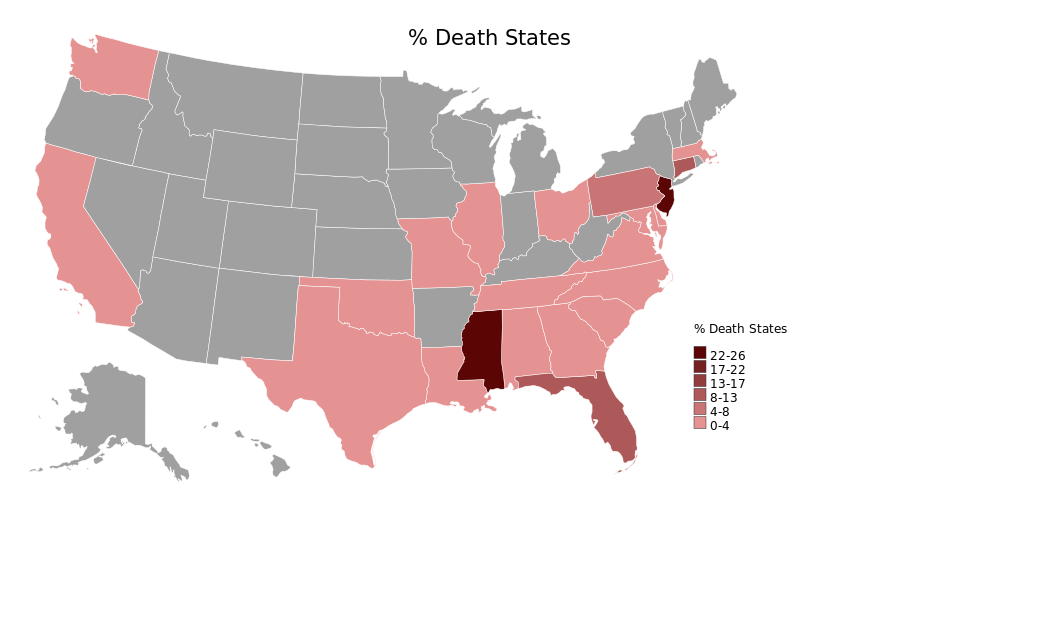

In [50]:
createMapUSA('DeathPct',  # Column to plot
             mapRed,  # Colors to use
             '% Death States',  # Title
             '% Death States',  # Legend Title
             legendScaleMin=0)  # Binary for if the lowest value should be the min value or 0

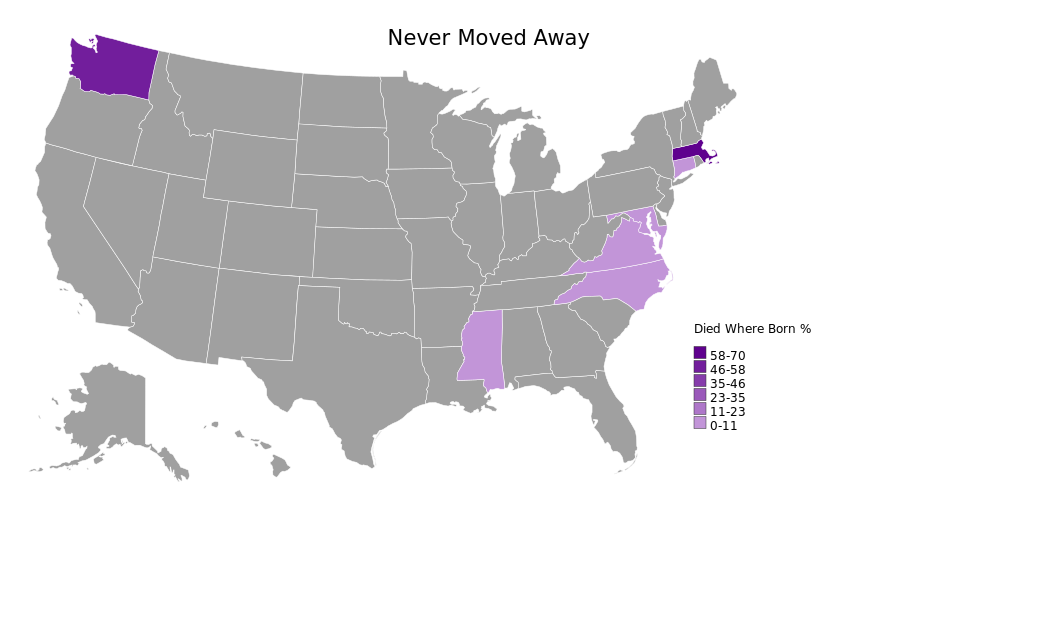

In [51]:
createMapUSA('DiedWhereBornPct',  # Column to plot
             mapPurple,  # Colors to use
             'Never Moved Away',  # Title
             'Died Where Born %',  # Legend Title
             legendScaleMin=0)  # Binary for if the lowest value should be the min value or 0

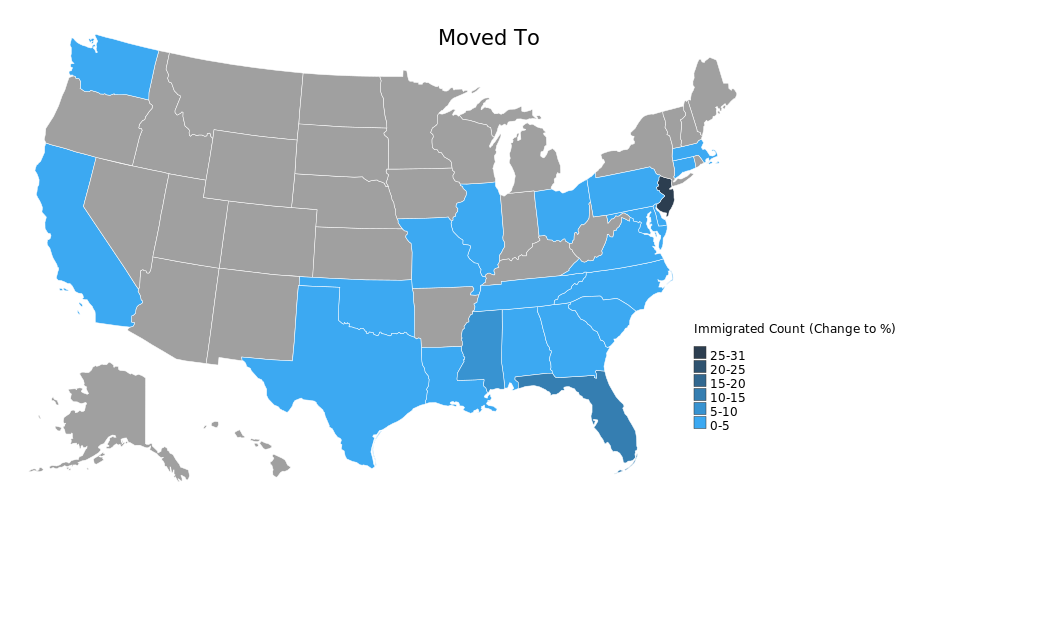

In [52]:
createMapUSA('ImmigratedCount',  # Column to plot
             mapBlue,  # Colors to use
             'Moved To',  # Title
             'Immigrated Count (Change to %)',  # Legend Title
             legendScaleMin=0)  # Binary for if the lowest value should be the min value or 0

### Ancestral Countries

In [53]:
euroMap = df['BirthCountry'].groupby(df['BirthCountry']).count()
euroMap.name = 'BirthCount'
euroMap = euroMap.reset_index()

# Removing non-European countries
euroMap = euroMap[(euroMap['BirthCountry'] != 'United States') & 
                    (euroMap['BirthCountry'] != 'Canada')]

def countryAbbrev(country):
    """
    Manually converting country names according to chorogrid's European country 
    name abbreviations due to dictionary containing multiple abbreviations per country
    """
    if country == 'England' or country == 'Scotland' or country == 'Wales':
        return 'GB'
    if country == 'France':
        return 'FR'
    if country == 'Italy':
        return 'IT'
    else:
        return np.NaN
    
euroMap['Country'] = euroMap['BirthCountry'].apply(lambda country: countryAbbrev(country))

euroMap

,BirthCountry,BirthCount,Country
1,England,13,GB
2,France,2,FR
3,Italy,2,IT
4,Scotland,5,GB
6,Wales,1,GB


We can see that Scotland, England, and Wales were assigned Great Britain, so now we have to group these again in order to aggregate them.

In [54]:
# Re-aggregating after England/Scotland/Wales were assigned GB
euroMap = euroMap.groupby('Country').sum().reset_index()

euroMap['AncestorPct'] = euroMap['BirthCount']/euroMap['BirthCount'].sum() * 100

In [55]:
# Adjusting for under-represented Italian ancestry
nonITCount = euroMap[euroMap['Country'] != 'IT']['BirthCount'].sum()
euroMap['AdjustedPct'] = np.where(euroMap['Country'] == 'IT', 50, (euroMap['BirthCount']/nonITCount * 100)/2)

euroMap

,Country,BirthCount,AncestorPct,AdjustedPct
0,FR,2,8.695652,4.761905
1,GB,19,82.608696,45.238095
2,IT,2,8.695652,50.000000


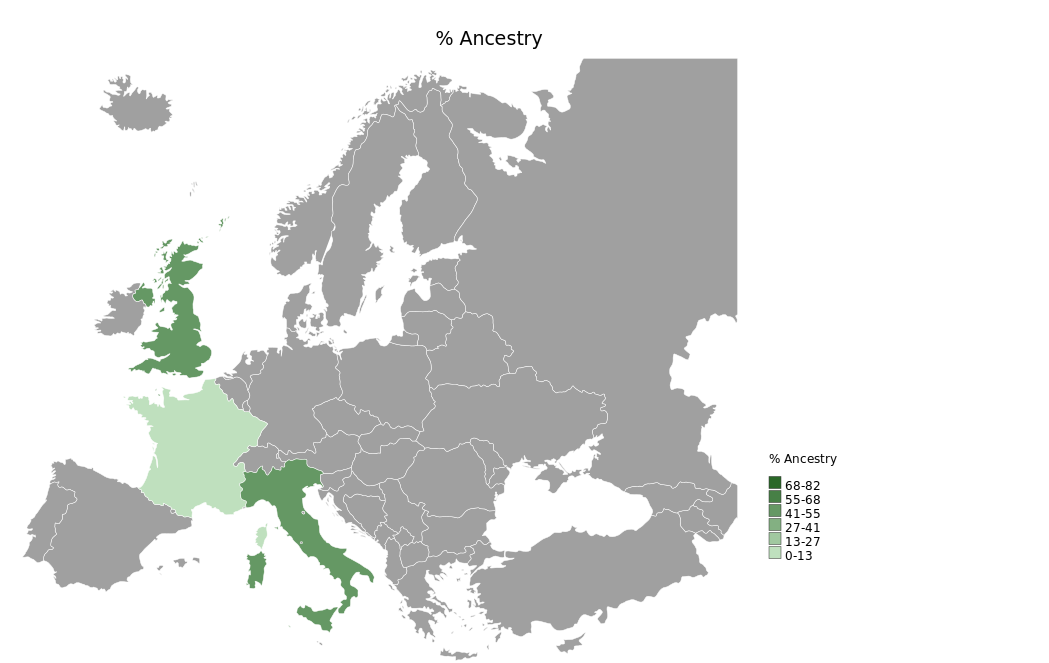

In [56]:
mapBin = Colorbin(euroMap['AdjustedPct'], mapGreen, proportional=False, decimals=None)
mapBin.fenceposts = mapLegendScale(euroMap['AncestorPct'])
mapBin.recalc(False)

cg = Chorogrid('europe_countries.csv', euroMap.Country, mapBin.colors_out, 'abbrev')
cg.set_title('% Ancestry', font_dict={'font-size': 19})
cg.set_legend(mapBin.colors_in, mapBin.labels, title='% Ancestry')
cg.draw_map(spacing_dict={'legend_offset':[-200,-100], 'margin_top': 50})
cg.done(show=True)

# To do

### - Map surnames to country of origin
### - Get geneology test to compare to country of origin